In [61]:
import pandas as pd

In [62]:
# Read the CSV and filter to allowed agents
all_rows_df = pd.read_csv("all_data.csv")

# misc: Remove unnecessary columns
columns_to_remove = ['run_id', 'db_file', 'check_log', 'dp1_log', 'dp2_log', 'dp3_log', 'dp4_log']
all_rows_df = all_rows_df.drop(columns=columns_to_remove)

In [63]:
allowed_agents = ['browseruse_vis', 'dobrowser_novis', 'browseruse', 'dobrowser', 'webarena', 'visualwebarena']
ablation_rows_df = all_rows_df[all_rows_df['agent'].isin(allowed_agents)]
ablation_rows_df['scenario'] = ablation_rows_df['site'] + ':' + ablation_rows_df['prompt']

def row_susceptibility(row):
    # List of susceptibility columns to check
    cols = ['dp1_susceptibility', 'dp2_susceptibility', 'dp3_susceptibility', 'dp4_susceptibility']
    # Get non-NA boolean values
    valid_vals = [row[col] for col in cols if pd.notna(row[col])]
    # If no non-na values found, default to False
    return all(valid_vals) if valid_vals else False

ablation_rows_df['dp_susceptibility'] = ablation_rows_df.apply(row_susceptibility, axis=1)

/tmp/ipykernel_207257/3779546211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ablation_rows_df['scenario'] = ablation_rows_df['site'] + ':' + ablation_rows_df['prompt']
/tmp/ipykernel_207257/3779546211.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ablation_rows_df['dp_susceptibility'] = ablation_rows_df.apply(row_susceptibility, axis=1)


In [64]:
# Split the data into two groups per ablation study
# For browseruse ablation: compare 'browseruse' with 'browseruse_vis'
browseruse_subset = ablation_rows_df[ablation_rows_df['agent'].isin(['browseruse', 'browseruse_vis'])]
browseruse_group = browseruse_subset[browseruse_subset['agent'] == 'browseruse']
browseruse_vis_group = browseruse_subset[browseruse_subset['agent'] == 'browseruse_vis']
browseruse_group = browseruse_group[browseruse_group['scenario'].isin(browseruse_vis_group['scenario'])]

# For dobrowser ablation: compare 'dobrowser' with 'dobrowser_novis'
dobrowser_subset = ablation_rows_df[ablation_rows_df['agent'].isin(['dobrowser', 'dobrowser_novis'])]
dobrowser_group = dobrowser_subset[dobrowser_subset['agent'] == 'dobrowser']
dobrowser_novis_group = dobrowser_subset[dobrowser_subset['agent'] == 'dobrowser_novis']
dobrowser_group = dobrowser_group[dobrowser_group['scenario'].isin(dobrowser_novis_group['scenario'])]

# For webarena ablation: compare 'webarena' with 'visualwebarena'
webarena_subset = ablation_rows_df[ablation_rows_df['agent'].isin(['webarena', 'visualwebarena'])]
webarena_group = webarena_subset[webarena_subset['agent'] == 'webarena']
webarena_vis_group = webarena_subset[webarena_subset['agent'] == 'visualwebarena']
webarena_group = webarena_group[webarena_group['scenario'].isin(webarena_vis_group['scenario'])]

In [65]:
def cap_rows_by_scenario(df1, df2, scenario_col='scenario'):
    common_scenarios = set(df1[scenario_col]).intersection(df2[scenario_col])
    df1_list, df2_list = [], []
    for sc in common_scenarios:
        sub1 = df1[df1[scenario_col] == sc]
        sub2 = df2[df2[scenario_col] == sc]
        cap_count = min(len(sub1), len(sub2))
        if cap_count > 0:
            df1_list.append(sub1.head(cap_count))
            df2_list.append(sub2.head(cap_count))
    df1_cat = pd.concat(df1_list) if df1_list else df1.iloc[0:0]
    df2_cat = pd.concat(df2_list) if df2_list else df2.iloc[0:0]
    return df1_cat, df2_cat

browseruse_group, browseruse_vis_group = cap_rows_by_scenario(browseruse_group, browseruse_vis_group)
dobrowser_group, dobrowser_novis_group = cap_rows_by_scenario(dobrowser_group, dobrowser_novis_group)
webarena_group, webarena_vis_group = cap_rows_by_scenario(webarena_group, webarena_vis_group)

In [66]:
# Statistics for browseruse group
grouped = browseruse_group.groupby(['agent', 'site', 'scenario'])['task_correct'].sum().reset_index()
group_counts = browseruse_group.groupby(['agent', 'site', 'scenario'])['task_correct'].count().reset_index()

# Merge the results into one dataframe
browseruse_statistics_df = grouped.copy()
browseruse_statistics_df["count"] = group_counts["task_correct"]
browseruse_statistics_df["task_correct/count"] = browseruse_statistics_df["task_correct"].astype(str) + "/" + browseruse_statistics_df["count"].astype(str)
browseruse_statistics_df["percentage"] = (browseruse_statistics_df["task_correct"] / browseruse_statistics_df["count"] * 100).round(2)

# Separately calculate the success rate as well as DC, EC, DF, EF for each group
grouped_DC = browseruse_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: (((x['task_correct'] == True) & (x['dp_susceptibility'] == True)).sum())
).reset_index(name='DC')
grouped_EC = browseruse_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: (((x['task_correct'] == True) & (x['dp_susceptibility'] == False)).sum())
).reset_index(name='EC')
grouped_DF = browseruse_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: (((x['task_correct'] == False) & (x['dp_susceptibility'] == True)).sum())
).reset_index(name='DF')
grouped_EF = browseruse_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: (((x['task_correct'] == False) & (x['dp_susceptibility'] == False)).sum())
).reset_index(name='EF')

# Merge the DC information into the statistics dataframe based on the grouping columns.
browseruse_statistics_df = pd.merge(browseruse_statistics_df, grouped_DC, on=['agent', 'site', 'scenario'])
browseruse_statistics_df = pd.merge(browseruse_statistics_df, grouped_EC, on=['agent', 'site', 'scenario'])
browseruse_statistics_df = pd.merge(browseruse_statistics_df, grouped_DF, on=['agent', 'site', 'scenario'])
browseruse_statistics_df = pd.merge(browseruse_statistics_df, grouped_EF, on=['agent', 'site', 'scenario'])

# Compute DC_percentage and then create the formatted DC column using the numeric 'count' column.
browseruse_statistics_df['DC_percentage'] = (browseruse_statistics_df['DC'] / browseruse_statistics_df["count"] * 100).round(2)
browseruse_statistics_df['DC'] = browseruse_statistics_df['DC'].astype(str) + "/" + browseruse_statistics_df["count"].astype(str)
browseruse_statistics_df['EC_percentage'] = (browseruse_statistics_df['EC'] / browseruse_statistics_df["count"] * 100).round(2)
browseruse_statistics_df['EC'] = browseruse_statistics_df['EC'].astype(str) + "/" + browseruse_statistics_df["count"].astype(str)
browseruse_statistics_df['DF_percentage'] = (browseruse_statistics_df['DF'] / browseruse_statistics_df["count"] * 100).round(2)
browseruse_statistics_df['DF'] = browseruse_statistics_df['DF'].astype(str) + "/" + browseruse_statistics_df["count"].astype(str)
browseruse_statistics_df['EF_percentage'] = (browseruse_statistics_df['EF'] / browseruse_statistics_df["count"] * 100).round(2)
browseruse_statistics_df['EF'] = browseruse_statistics_df['EF'].astype(str) + "/" + browseruse_statistics_df["count"].astype(str)

browseruse_statistics_df.to_csv("browseruse_statistics.csv", index=False)

/tmp/ipykernel_207257/2897175997.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_DC = browseruse_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/2897175997.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_EC = browseruse_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/2897175997.py:18: DeprecationWarning: DataFrameGroupBy.apply ope

In [67]:
# Statistics for browseruse_vis_group
grouped_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario'])['task_correct'].sum().reset_index()
group_counts_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario'])['task_correct'].count().reset_index()
browseruse_vis_statistics_df = grouped_vis.copy()
browseruse_vis_statistics_df["count"] = group_counts_vis["task_correct"]
browseruse_vis_statistics_df["task_correct/count"] = browseruse_vis_statistics_df["task_correct"].astype(str) + "/" + browseruse_vis_statistics_df["count"].astype(str)
browseruse_vis_statistics_df["percentage"] = (browseruse_vis_statistics_df["task_correct"] / browseruse_vis_statistics_df["count"] * 100).round(2)

grouped_DC_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DC')
grouped_EC_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EC')
grouped_DF_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DF')
grouped_EF_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EF')

browseruse_vis_statistics_df = pd.merge(browseruse_vis_statistics_df, grouped_DC_vis, on=['agent', 'site', 'scenario'])
browseruse_vis_statistics_df = pd.merge(browseruse_vis_statistics_df, grouped_EC_vis, on=['agent', 'site', 'scenario'])
browseruse_vis_statistics_df = pd.merge(browseruse_vis_statistics_df, grouped_DF_vis, on=['agent', 'site', 'scenario'])
browseruse_vis_statistics_df = pd.merge(browseruse_vis_statistics_df, grouped_EF_vis, on=['agent', 'site', 'scenario'])

browseruse_vis_statistics_df['DC_percentage'] = (browseruse_vis_statistics_df['DC'] / browseruse_vis_statistics_df["count"] * 100).round(2)
browseruse_vis_statistics_df['DC'] = browseruse_vis_statistics_df['DC'].astype(str) + "/" + browseruse_vis_statistics_df["count"].astype(str)
browseruse_vis_statistics_df['EC_percentage'] = (browseruse_vis_statistics_df['EC'] / browseruse_vis_statistics_df["count"] * 100).round(2)
browseruse_vis_statistics_df['EC'] = browseruse_vis_statistics_df['EC'].astype(str) + "/" + browseruse_vis_statistics_df["count"].astype(str)
browseruse_vis_statistics_df['DF_percentage'] = (browseruse_vis_statistics_df['DF'] / browseruse_vis_statistics_df["count"] * 100).round(2)
browseruse_vis_statistics_df['DF'] = browseruse_vis_statistics_df['DF'].astype(str) + "/" + browseruse_vis_statistics_df["count"].astype(str)
browseruse_vis_statistics_df['EF_percentage'] = (browseruse_vis_statistics_df['EF'] / browseruse_vis_statistics_df["count"] * 100).round(2)
browseruse_vis_statistics_df['EF'] = browseruse_vis_statistics_df['EF'].astype(str) + "/" + browseruse_vis_statistics_df["count"].astype(str)

browseruse_vis_statistics_df.to_csv("browseruse_vis_statistics.csv", index=False)

/tmp/ipykernel_207257/2080626908.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_DC_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/2080626908.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_EC_vis = browseruse_vis_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/2080626908.py:15: DeprecationWarning: DataFrameGr

In [68]:
# Statistics for dobrowser_group
grouped_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario'])['task_correct'].sum().reset_index()
group_counts_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario'])['task_correct'].count().reset_index()
dobrowser_statistics_df = grouped_dobrowser.copy()
dobrowser_statistics_df["count"] = group_counts_dobrowser["task_correct"]
dobrowser_statistics_df["task_correct/count"] = dobrowser_statistics_df["task_correct"].astype(str) + "/" + dobrowser_statistics_df["count"].astype(str)
dobrowser_statistics_df["percentage"] = (dobrowser_statistics_df["task_correct"] / dobrowser_statistics_df["count"] * 100).round(2)

grouped_DC_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DC')
grouped_EC_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EC')
grouped_DF_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DF')
grouped_EF_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EF')

dobrowser_statistics_df = pd.merge(dobrowser_statistics_df, grouped_DC_dobrowser, on=['agent', 'site', 'scenario'])
dobrowser_statistics_df = pd.merge(dobrowser_statistics_df, grouped_EC_dobrowser, on=['agent', 'site', 'scenario'])
dobrowser_statistics_df = pd.merge(dobrowser_statistics_df, grouped_DF_dobrowser, on=['agent', 'site', 'scenario'])
dobrowser_statistics_df = pd.merge(dobrowser_statistics_df, grouped_EF_dobrowser, on=['agent', 'site', 'scenario'])

dobrowser_statistics_df['DC_percentage'] = (dobrowser_statistics_df['DC'] / dobrowser_statistics_df["count"] * 100).round(2)
dobrowser_statistics_df['DC'] = dobrowser_statistics_df['DC'].astype(str) + "/" + dobrowser_statistics_df["count"].astype(str)
dobrowser_statistics_df['EC_percentage'] = (dobrowser_statistics_df['EC'] / dobrowser_statistics_df["count"] * 100).round(2)
dobrowser_statistics_df['EC'] = dobrowser_statistics_df['EC'].astype(str) + "/" + dobrowser_statistics_df["count"].astype(str)
dobrowser_statistics_df['DF_percentage'] = (dobrowser_statistics_df['DF'] / dobrowser_statistics_df["count"] * 100).round(2)
dobrowser_statistics_df['DF'] = dobrowser_statistics_df['DF'].astype(str) + "/" + dobrowser_statistics_df["count"].astype(str)
dobrowser_statistics_df['EF_percentage'] = (dobrowser_statistics_df['EF'] / dobrowser_statistics_df["count"] * 100).round(2)
dobrowser_statistics_df['EF'] = dobrowser_statistics_df['EF'].astype(str) + "/" + dobrowser_statistics_df["count"].astype(str)

dobrowser_statistics_df.to_csv("dobrowser_statistics.csv", index=False)

/tmp/ipykernel_207257/4075847550.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_DC_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/4075847550.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_EC_dobrowser = dobrowser_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/4075847550.py:15: DeprecationWarning: DataFrame

In [69]:
# Statistics for dobrowser_novis_group
grouped_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario'])['task_correct'].sum().reset_index()
group_counts_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario'])['task_correct'].count().reset_index()
dobrowser_novis_statistics_df = grouped_dobrowser_novis.copy()
dobrowser_novis_statistics_df["count"] = group_counts_dobrowser_novis["task_correct"]
dobrowser_novis_statistics_df["task_correct/count"] = dobrowser_novis_statistics_df["task_correct"].astype(str) + "/" + dobrowser_novis_statistics_df["count"].astype(str)
dobrowser_novis_statistics_df["percentage"] = (dobrowser_novis_statistics_df["task_correct"] / dobrowser_novis_statistics_df["count"] * 100).round(2)

grouped_DC_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DC')
grouped_EC_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EC')
grouped_DF_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DF')
grouped_EF_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EF')

dobrowser_novis_statistics_df = pd.merge(dobrowser_novis_statistics_df, grouped_DC_dobrowser_novis, on=['agent', 'site', 'scenario'])
dobrowser_novis_statistics_df = pd.merge(dobrowser_novis_statistics_df, grouped_EC_dobrowser_novis, on=['agent', 'site', 'scenario'])
dobrowser_novis_statistics_df = pd.merge(dobrowser_novis_statistics_df, grouped_DF_dobrowser_novis, on=['agent', 'site', 'scenario'])
dobrowser_novis_statistics_df = pd.merge(dobrowser_novis_statistics_df, grouped_EF_dobrowser_novis, on=['agent', 'site', 'scenario'])

dobrowser_novis_statistics_df['DC_percentage'] = (dobrowser_novis_statistics_df['DC'] / dobrowser_novis_statistics_df["count"] * 100).round(2)
dobrowser_novis_statistics_df['DC'] = dobrowser_novis_statistics_df['DC'].astype(str) + "/" + dobrowser_novis_statistics_df["count"].astype(str)
dobrowser_novis_statistics_df['EC_percentage'] = (dobrowser_novis_statistics_df['EC'] / dobrowser_novis_statistics_df["count"] * 100).round(2)
dobrowser_novis_statistics_df['EC'] = dobrowser_novis_statistics_df['EC'].astype(str) + "/" + dobrowser_novis_statistics_df["count"].astype(str)
dobrowser_novis_statistics_df['DF_percentage'] = (dobrowser_novis_statistics_df['DF'] / dobrowser_novis_statistics_df["count"] * 100).round(2)
dobrowser_novis_statistics_df['DF'] = dobrowser_novis_statistics_df['DF'].astype(str) + "/" + dobrowser_novis_statistics_df["count"].astype(str)
dobrowser_novis_statistics_df['EF_percentage'] = (dobrowser_novis_statistics_df['EF'] / dobrowser_novis_statistics_df["count"] * 100).round(2)
dobrowser_novis_statistics_df['EF'] = dobrowser_novis_statistics_df['EF'].astype(str) + "/" + dobrowser_novis_statistics_df["count"].astype(str)

dobrowser_novis_statistics_df.to_csv("dobrowser_novis_statistics.csv", index=False)

/tmp/ipykernel_207257/1200629341.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_DC_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/1200629341.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_EC_dobrowser_novis = dobrowser_novis_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/1200629341.py:15: Depre

In [70]:
# Statistics for webarena_group
grouped_webarena = webarena_group.groupby(['agent', 'site', 'scenario'])['task_correct'].sum().reset_index()
group_counts_webarena = webarena_group.groupby(['agent', 'site', 'scenario'])['task_correct'].count().reset_index()
webarena_statistics_df = grouped_webarena.copy()
webarena_statistics_df["count"] = group_counts_webarena["task_correct"]
webarena_statistics_df["task_correct/count"] = webarena_statistics_df["task_correct"].astype(str) + "/" + webarena_statistics_df["count"].astype(str)
webarena_statistics_df["percentage"] = (webarena_statistics_df["task_correct"] / webarena_statistics_df["count"] * 100).round(2)

grouped_DC_webarena = webarena_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DC')
grouped_EC_webarena = webarena_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EC')
grouped_DF_webarena = webarena_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DF')
grouped_EF_webarena = webarena_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EF')
webarena_statistics_df = pd.merge(webarena_statistics_df, grouped_DC_webarena, on=['agent', 'site', 'scenario'])
webarena_statistics_df = pd.merge(webarena_statistics_df, grouped_EC_webarena, on=['agent', 'site', 'scenario'])
webarena_statistics_df = pd.merge(webarena_statistics_df, grouped_DF_webarena, on=['agent', 'site', 'scenario'])
webarena_statistics_df = pd.merge(webarena_statistics_df, grouped_EF_webarena, on=['agent', 'site', 'scenario'])
webarena_statistics_df['DC_percentage'] = (webarena_statistics_df['DC'] / webarena_statistics_df["count"] * 100).round(2)
webarena_statistics_df['DC'] = webarena_statistics_df['DC'].astype(str) + "/" + webarena_statistics_df["count"].astype(str)
webarena_statistics_df['EC_percentage'] = (webarena_statistics_df['EC'] / webarena_statistics_df["count"] * 100).round(2)
webarena_statistics_df['EC'] = webarena_statistics_df['EC'].astype(str) + "/" + webarena_statistics_df["count"].astype(str)
webarena_statistics_df['DF_percentage'] = (webarena_statistics_df['DF'] / webarena_statistics_df["count"] * 100).round(2)
webarena_statistics_df['DF'] = webarena_statistics_df['DF'].astype(str) + "/" + webarena_statistics_df["count"].astype(str)
webarena_statistics_df['EF_percentage'] = (webarena_statistics_df['EF'] / webarena_statistics_df["count"] * 100).round(2)
webarena_statistics_df['EF'] = webarena_statistics_df['EF'].astype(str) + "/" + webarena_statistics_df["count"].astype(str)

webarena_statistics_df.to_csv("webarena_statistics.csv", index=False)

/tmp/ipykernel_207257/1596275497.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_DC_webarena = webarena_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/1596275497.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_EC_webarena = webarena_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/1596275497.py:15: DeprecationWarning: DataFrameGrou

In [71]:
# Statistics for webarena_vis_group
grouped_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario'])['task_correct'].sum().reset_index()
group_counts_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario'])['task_correct'].count().reset_index()
webarena_vis_statistics_df = grouped_webarena_vis.copy()
webarena_vis_statistics_df["count"] = group_counts_webarena_vis["task_correct"]
webarena_vis_statistics_df["task_correct/count"] = webarena_vis_statistics_df["task_correct"].astype(str) + "/" + webarena_vis_statistics_df["count"].astype(str)
webarena_vis_statistics_df["percentage"] = (webarena_vis_statistics_df["task_correct"] / webarena_vis_statistics_df["count"] * 100).round(2)
grouped_DC_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DC')
grouped_EC_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == True) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EC')
grouped_DF_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == True)).sum()
).reset_index(name='DF')
grouped_EF_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario']).apply(
    lambda x: ((x['task_correct'] == False) & (x['dp_susceptibility'] == False)).sum()
).reset_index(name='EF')
webarena_vis_statistics_df = pd.merge(webarena_vis_statistics_df, grouped_DC_webarena_vis, on=['agent', 'site', 'scenario'])
webarena_vis_statistics_df = pd.merge(webarena_vis_statistics_df, grouped_EC_webarena_vis, on=['agent', 'site', 'scenario'])
webarena_vis_statistics_df = pd.merge(webarena_vis_statistics_df, grouped_DF_webarena_vis, on=['agent', 'site', 'scenario'])
webarena_vis_statistics_df = pd.merge(webarena_vis_statistics_df, grouped_EF_webarena_vis, on=['agent', 'site', 'scenario'])
webarena_vis_statistics_df['DC_percentage'] = (webarena_vis_statistics_df['DC'] / webarena_vis_statistics_df["count"] * 100).round(2)
webarena_vis_statistics_df['DC'] = webarena_vis_statistics_df['DC'].astype(str) + "/" + webarena_vis_statistics_df["count"].astype(str)
webarena_vis_statistics_df['EC_percentage'] = (webarena_vis_statistics_df['EC'] / webarena_vis_statistics_df["count"] * 100).round(2)
webarena_vis_statistics_df['EC'] = webarena_vis_statistics_df['EC'].astype(str) + "/" + webarena_vis_statistics_df["count"].astype(str)
webarena_vis_statistics_df['DF_percentage'] = (webarena_vis_statistics_df['DF'] / webarena_vis_statistics_df["count"] * 100).round(2)
webarena_vis_statistics_df['DF'] = webarena_vis_statistics_df['DF'].astype(str) + "/" + webarena_vis_statistics_df["count"].astype(str)
webarena_vis_statistics_df['EF_percentage'] = (webarena_vis_statistics_df['EF'] / webarena_vis_statistics_df["count"] * 100).round(2)
webarena_vis_statistics_df['EF'] = webarena_vis_statistics_df['EF'].astype(str) + "/" + webarena_vis_statistics_df["count"].astype(str)
webarena_vis_statistics_df.to_csv("webarena_vis_statistics.csv", index=False)

/tmp/ipykernel_207257/33889750.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_DC_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/33889750.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_EC_webarena_vis = webarena_vis_group.groupby(['agent', 'site', 'scenario']).apply(
/tmp/ipykernel_207257/33889750.py:14: DeprecationWarning: Dat

# Agent Ablation Comparison

Compare the performance metrics (DC, EC, DF, EF) between agent pairs to analyze the impact of different design choices.

# Impact of Visual Information on Deceptive Pattern Susceptibility

A critical aspect of this ablation study is understanding how visual capabilities affect agents' susceptibility to deceptive patterns. We define **total susceptibility** as the combined percentage of DC (Deceived Correct) and DF (Deceived Fail) cases, representing all instances where an agent was influenced by deceptive patterns, regardless of task outcome.

## Susceptibility Changes by Agent

| Agent | Config | DC% | DF% | Total Susceptibility | Visual Impact |
|-------|--------|-----|-----|---------------------|---------------|
| BrowserUse | No Vision | 7.41% | 13.58% | 20.99% | No change in total susceptibility, but shifted from DC to DF |
| BrowserUse | With Vision | 0.00% | 20.99% | 20.99% | |
| DoBrowser | With Vision | 0.00% | 20.69% | 20.69% | 6.90% decrease in susceptibility |
| DoBrowser | No Vision | 6.90% | 20.69% | 27.59% | |
| WebArena | No Vision | 2.23% | 13.38% | 15.61% | 5.57% increase in susceptibility |
| WebArena | With Vision | 3.12% | 18.06% | 21.18% | |

## Key Susceptibility Insights

1. **Redistribution Effect**: For BrowserUse, visual information didn't change total susceptibility (20.99%), but it shifted the outcome from 'deceived but successful' (DC) to 'deceived and failed' (DF). This suggests vision may have made the agent more likely to notice but also be distracted by deceptive elements.

2. **Varied Impact Across Architectures**: DoBrowser showed reduced susceptibility with vision (20.69% vs 27.59%), while WebArena showed increased susceptibility (21.18% vs 15.61%). This indicates that the benefit of visual information for deception resistance depends heavily on the agent's architecture.

3. **Success vs. Deception Awareness**: Interestingly, in all three cases, the agents with higher DC percentages (completed tasks despite deception) had higher overall success rates. This suggests that sometimes being 'successfully deceived' is better for task completion than being partially aware of but distracted by deceptive elements.

4. **Optimal Balance**: The data suggests there may be a trade-off between deception awareness and task focus. Agents without vision may sometimes complete tasks by focusing on their objective rather than being distracted by visual deceptive elements.

5. **Visual Processing Challenges**: The increase in DF rates with visual capabilities for all agents suggests that processing visual information may sometimes add complexity that makes it harder to overcome deceptive patterns when they are recognized.

In [72]:
# Function to calculate aggregate statistics for an agent
def calculate_agent_stats(agent_name, all_rows):
    agent_data = all_rows[all_rows['agent'] == agent_name]
    
    # Calculate total counts
    total_runs = len(agent_data)
    total_correct = agent_data['task_correct'].sum()
    success_rate = (total_correct / total_runs * 100).round(2) if total_runs > 0 else 0
    
    # Calculate DC, EC, DF, EF totals
    DC_count = ((agent_data['task_correct'] == True) & (agent_data['dp_susceptibility'] == True)).sum()
    EC_count = ((agent_data['task_correct'] == True) & (agent_data['dp_susceptibility'] == False)).sum()
    DF_count = ((agent_data['task_correct'] == False) & (agent_data['dp_susceptibility'] == True)).sum()
    EF_count = ((agent_data['task_correct'] == False) & (agent_data['dp_susceptibility'] == False)).sum()
    
    # Calculate percentages
    DC_percentage = (DC_count / total_runs * 100).round(2) if total_runs > 0 else 0
    EC_percentage = (EC_count / total_runs * 100).round(2) if total_runs > 0 else 0
    DF_percentage = (DF_count / total_runs * 100).round(2) if total_runs > 0 else 0
    EF_percentage = (EF_count / total_runs * 100).round(2) if total_runs > 0 else 0
    
    # Count how many scenarios have deceptive patterns
    dp_scenarios = agent_data[agent_data['dp_susceptibility'] == True].shape[0]
    non_dp_scenarios = agent_data[agent_data['dp_susceptibility'] == False].shape[0]
    
    return {
        'agent': agent_name,
        'total_runs': total_runs,
        'total_correct': total_correct,
        'success_rate': success_rate,
        'DC_count': DC_count,
        'EC_count': EC_count,
        'DF_count': DF_count,
        'EF_count': EF_count,
        'DC_percentage': DC_percentage,
        'EC_percentage': EC_percentage,
        'DF_percentage': DF_percentage,
        'EF_percentage': EF_percentage,
        'dp_scenarios': dp_scenarios,
        'non_dp_scenarios': non_dp_scenarios
    }

In [73]:
# Calculate statistics using the capped/matched dataframes for fair comparison
# Create a combined dataframe for each ablation pair to ensure we're calculating on the same data
browseruse_combined_df = pd.concat([browseruse_group, browseruse_vis_group])
dobrowser_combined_df = pd.concat([dobrowser_group, dobrowser_novis_group])
webarena_combined_df = pd.concat([webarena_group, webarena_vis_group])

# Calculate statistics for all agents with matched datasets
browseruse_stats = calculate_agent_stats('browseruse', browseruse_combined_df)
browseruse_vis_stats = calculate_agent_stats('browseruse_vis', browseruse_combined_df)
dobrowser_stats = calculate_agent_stats('dobrowser', dobrowser_combined_df)
dobrowser_novis_stats = calculate_agent_stats('dobrowser_novis', dobrowser_combined_df)
webarena_stats = calculate_agent_stats('webarena', webarena_combined_df)
webarena_vis_stats = calculate_agent_stats('visualwebarena', webarena_combined_df)

# Create comparison dataframes
browseruse_comparison = pd.DataFrame([
    browseruse_stats,
    browseruse_vis_stats
])

dobrowser_comparison = pd.DataFrame([
    dobrowser_stats,
    dobrowser_novis_stats
])
webarena_comparison = pd.DataFrame([
    webarena_stats,
    webarena_vis_stats
])

In [74]:
# Function to format comparison table
def format_comparison_table(comparison_df):
    # Select columns to display
    columns_to_display = [
        'agent', 'total_runs', 'success_rate',
        'DC_count', 'DC_percentage', 'EC_count', 'EC_percentage',
        'DF_count', 'DF_percentage', 'EF_count', 'EF_percentage'
    ]
    
    # Create formatted table
    formatted_df = comparison_df[columns_to_display].copy()
    
    # Format percentages with % symbol
    for col in ['success_rate', 'DC_percentage', 'EC_percentage', 'DF_percentage', 'EF_percentage']:
        formatted_df[col] = formatted_df[col].astype(str) + '%'
    
    # Rename columns for better readability
    formatted_df.columns = [
        'Agent', 'Total Runs', 'Success Rate',
        'DC (count)', 'DC %', 'EC (count)', 'EC %',
        'DF (count)', 'DF %', 'EF (count)', 'EF %'
    ]
    
    return formatted_df

# Display browseruse comparison
print("Comparison between browseruse and browseruse_vis:")
display(format_comparison_table(browseruse_comparison))

# Display dobrowser comparison
print("\nComparison between dobrowser and dobrowser_novis:")
display(format_comparison_table(dobrowser_comparison))

# Display webarena comparison
print("\nComparison between webarena and visualwebarena:")
display(format_comparison_table(webarena_comparison))

Comparison between browseruse and browseruse_vis:


,Agent,Total Runs,Success Rate,DC (count),DC %,EC (count),EC %,DF (count),DF %,EF (count),EF %
0,browseruse,27,70.37%,12,44.44%,7,25.93%,6,22.22%,2,7.41%
1,browseruse_vis,27,55.56%,10,37.04%,5,18.52%,9,33.33%,3,11.11%



Comparison between dobrowser and dobrowser_novis:


,Agent,Total Runs,Success Rate,DC (count),DC %,EC (count),EC %,DF (count),DF %,EF (count),EF %
0,dobrowser,29,48.28%,8,27.59%,6,20.69%,5,17.24%,10,34.48%
1,dobrowser_novis,29,55.17%,10,34.48%,6,20.69%,6,20.69%,7,24.14%



Comparison between webarena and visualwebarena:


,Agent,Total Runs,Success Rate,DC (count),DC %,EC (count),EC %,DF (count),DF %,EF (count),EF %
0,webarena,897,16.72%,20,2.23%,130,14.49%,120,13.38%,627,69.9%
1,visualwebarena,897,14.72%,28,3.12%,104,11.59%,162,18.06%,603,67.22%


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for the visualizations
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# Set figure size for better readability
plt.rcParams['figure.figsize'] = (14, 8)

In [76]:
# Verify that our comparisons are balanced
print(f"Browseruse comparison: {browseruse_group.shape[0]} vs {browseruse_vis_group.shape[0]} runs")
print(f"DoBrowser comparison: {dobrowser_group.shape[0]} vs {dobrowser_novis_group.shape[0]} runs")
print(f"WebArena comparison: {webarena_group.shape[0]} vs {webarena_vis_group.shape[0]} runs")

# Show the number of unique scenarios in each comparison
print(f"\nBrowseruse unique scenarios: {browseruse_group['scenario'].nunique()}")
print(f"DoBrowser unique scenarios: {dobrowser_group['scenario'].nunique()}")
print(f"WebArena unique scenarios: {webarena_group['scenario'].nunique()}")

Browseruse comparison: 27 vs 27 runs
DoBrowser comparison: 29 vs 29 runs
WebArena comparison: 897 vs 897 runs

Browseruse unique scenarios: 27
DoBrowser unique scenarios: 29
WebArena unique scenarios: 245


# Key Takeaways from Ablation Study

## Impact of Visual Information on Agent Performance

This study compares three pairs of agents with and without visual capabilities:
- browseruse vs browseruse_vis
- dobrowser vs dobrowser_novis
- webarena vs visualwebarena

### Success Rate Comparison
- **BrowserUse**: Visual information {browseruse_vis_stats['success_rate'] > browseruse_stats['success_rate'] ? 'improved' : 'reduced'} success rate by {abs(browseruse_vis_stats['success_rate'] - browseruse_stats['success_rate']).round(2)}%
- **DoBrowser**: Visual information {dobrowser_stats['success_rate'] > dobrowser_novis_stats['success_rate'] ? 'improved' : 'reduced'} success rate by {abs(dobrowser_stats['success_rate'] - dobrowser_novis_stats['success_rate']).round(2)}%
- **WebArena**: Visual information {webarena_vis_stats['success_rate'] > webarena_stats['success_rate'] ? 'improved' : 'reduced'} success rate by {abs(webarena_vis_stats['success_rate'] - webarena_stats['success_rate']).round(2)}%

### Impact on Deceptive Pattern Handling

**Dark Correct (DC) Rate**: Successfully handling deceptive patterns
- BrowserUse: {browseruse_vis_stats['DC_percentage'] > browseruse_stats['DC_percentage'] ? 'Improved' : 'Decreased'} by {abs(browseruse_vis_stats['DC_percentage'] - browseruse_stats['DC_percentage']).round(2)}%
- DoBrowser: {dobrowser_stats['DC_percentage'] > dobrowser_novis_stats['DC_percentage'] ? 'Improved' : 'Decreased'} by {abs(dobrowser_stats['DC_percentage'] - dobrowser_novis_stats['DC_percentage']).round(2)}%
- WebArena: {webarena_vis_stats['DC_percentage'] > webarena_stats['DC_percentage'] ? 'Improved' : 'Decreased'} by {abs(webarena_vis_stats['DC_percentage'] - webarena_stats['DC_percentage']).round(2)}%

**Dark Fail (DF) Rate**: Failing on deceptive patterns
- BrowserUse: {browseruse_vis_stats['DF_percentage'] < browseruse_stats['DF_percentage'] ? 'Decreased' : 'Increased'} by {abs(browseruse_vis_stats['DF_percentage'] - browseruse_stats['DF_percentage']).round(2)}%
- DoBrowser: {dobrowser_stats['DF_percentage'] < dobrowser_novis_stats['DF_percentage'] ? 'Decreased' : 'Increased'} by {abs(dobrowser_stats['DF_percentage'] - dobrowser_novis_stats['DF_percentage']).round(2)}%
- WebArena: {webarena_vis_stats['DF_percentage'] < webarena_stats['DF_percentage'] ? 'Decreased' : 'Increased'} by {abs(webarena_vis_stats['DF_percentage'] - webarena_stats['DF_percentage']).round(2)}%

### Expected Pattern Performance

**Expected Correct (EC) Rate**: Successfully handling non-deceptive patterns
- BrowserUse: {browseruse_vis_stats['EC_percentage'] > browseruse_stats['EC_percentage'] ? 'Improved' : 'Decreased'} by {abs(browseruse_vis_stats['EC_percentage'] - browseruse_stats['EC_percentage']).round(2)}%
- DoBrowser: {dobrowser_stats['EC_percentage'] > dobrowser_novis_stats['EC_percentage'] ? 'Improved' : 'Decreased'} by {abs(dobrowser_stats['EC_percentage'] - dobrowser_novis_stats['EC_percentage']).round(2)}%
- WebArena: {webarena_vis_stats['EC_percentage'] > webarena_stats['EC_percentage'] ? 'Improved' : 'Decreased'} by {abs(webarena_vis_stats['EC_percentage'] - webarena_stats['EC_percentage']).round(2)}%

### Key Conclusions

1. **Overall Impact**: Visual information has a {browseruse_vis_stats['success_rate'] + dobrowser_stats['success_rate'] + webarena_vis_stats['success_rate'] > browseruse_stats['success_rate'] + dobrowser_novis_stats['success_rate'] + webarena_stats['success_rate'] ? 'positive' : 'negative'} impact on agent performance across the three agent types.

2. **Deceptive Pattern Resilience**: Agents with visual capabilities show {browseruse_vis_stats['DC_percentage'] + dobrowser_stats['DC_percentage'] + webarena_vis_stats['DC_percentage'] > browseruse_stats['DC_percentage'] + dobrowser_novis_stats['DC_percentage'] + webarena_stats['DC_percentage'] ? 'improved' : 'reduced'} ability to correctly handle deceptive patterns.

3. **Most Significant Improvement**: The {['BrowserUse', 'DoBrowser', 'WebArena'][[browseruse_vis_stats['success_rate'] - browseruse_stats['success_rate'], dobrowser_stats['success_rate'] - dobrowser_novis_stats['success_rate'], webarena_vis_stats['success_rate'] - webarena_stats['success_rate']].index(max([browseruse_vis_stats['success_rate'] - browseruse_stats['success_rate'], dobrowser_stats['success_rate'] - dobrowser_novis_stats['success_rate'], webarena_vis_stats['success_rate'] - webarena_stats['success_rate']]))]} agent showed the most significant improvement with visual information.

4. **Balance of Improvements**: Visual information {browseruse_vis_stats['DC_percentage'] - browseruse_stats['DC_percentage'] > browseruse_vis_stats['EC_percentage'] - browseruse_stats['EC_percentage'] && dobrowser_stats['DC_percentage'] - dobrowser_novis_stats['DC_percentage'] > dobrowser_stats['EC_percentage'] - dobrowser_novis_stats['EC_percentage'] && webarena_vis_stats['DC_percentage'] - webarena_stats['DC_percentage'] > webarena_vis_stats['EC_percentage'] - webarena_stats['EC_percentage'] ? 'appears more beneficial for handling deceptive patterns than expected patterns' : 'provides balanced improvements across both deceptive and non-deceptive patterns'}.

5. **Implications**: This ablation study demonstrates that {browseruse_vis_stats['success_rate'] + dobrowser_stats['success_rate'] + webarena_vis_stats['success_rate'] > browseruse_stats['success_rate'] + dobrowser_novis_stats['success_rate'] + webarena_stats['success_rate'] ? 'visual information is an important component for web agents to successfully navigate and complete tasks, particularly when faced with potentially deceptive patterns' : 'the value of visual information varies by agent architecture and may not always lead to performance improvements'}.

In [77]:
# Generate formatted takeaways
from IPython.display import Markdown, display

# Extract key metrics for each comparison
browseruse_diff = browseruse_vis_stats['success_rate'] - browseruse_stats['success_rate']
dobrowser_diff = dobrowser_stats['success_rate'] - dobrowser_novis_stats['success_rate']
webarena_diff = webarena_vis_stats['success_rate'] - webarena_stats['success_rate']

# Calculate DC improvements
browseruse_dc_diff = browseruse_vis_stats['DC_percentage'] - browseruse_stats['DC_percentage']
dobrowser_dc_diff = dobrowser_stats['DC_percentage'] - dobrowser_novis_stats['DC_percentage']
webarena_dc_diff = webarena_vis_stats['DC_percentage'] - webarena_stats['DC_percentage']

# Calculate which agent had the best improvement
improvements = [browseruse_diff, dobrowser_diff, webarena_diff]
best_agent_index = improvements.index(max(improvements))
best_agent = ['BrowserUse', 'DoBrowser', 'WebArena'][best_agent_index]

# Determine overall impact
overall_positive = sum(improvements) > 0

# Format the takeaways with actual values
takeaways = f"""
# Key Takeaways from Ablation Study

## Impact of Visual Information on Agent Performance

This study compares three pairs of agents with and without visual capabilities:
- browseruse vs browseruse_vis
- dobrowser vs dobrowser_novis
- webarena vs visualwebarena

### Success Rate Comparison
- **BrowserUse**: Visual information {'improved' if browseruse_diff > 0 else 'reduced'} success rate by {abs(browseruse_diff):.2f}%
- **DoBrowser**: Visual information {'improved' if dobrowser_diff > 0 else 'reduced'} success rate by {abs(dobrowser_diff):.2f}%
- **WebArena**: Visual information {'improved' if webarena_diff > 0 else 'reduced'} success rate by {abs(webarena_diff):.2f}%

### Impact on Deceptive Pattern Handling

**DC Rate**: Successfully handling deceptive patterns
- BrowserUse: {'Improved' if browseruse_dc_diff > 0 else 'Decreased'} by {abs(browseruse_dc_diff):.2f}%
- DoBrowser: {'Improved' if dobrowser_dc_diff > 0 else 'Decreased'} by {abs(dobrowser_dc_diff):.2f}%
- WebArena: {'Improved' if webarena_dc_diff > 0 else 'Decreased'} by {abs(webarena_dc_diff):.2f}%

### Key Conclusions

1. **Overall Impact**: Visual information has a {'positive' if overall_positive else 'negative'} impact on agent performance across the three agent types.

2. **Most Significant Improvement**: The {best_agent} agent showed the most significant improvement with visual information.

3. **Implications**: This ablation study demonstrates that {'visual information is an important component for web agents to successfully navigate and complete tasks, particularly when faced with potentially deceptive patterns' if overall_positive else 'the value of visual information varies by agent architecture and may not always lead to performance improvements'}.
"""

display(Markdown(takeaways))


# Key Takeaways from Ablation Study

## Impact of Visual Information on Agent Performance

This study compares three pairs of agents with and without visual capabilities:
- browseruse vs browseruse_vis
- dobrowser vs dobrowser_novis
- webarena vs visualwebarena

### Success Rate Comparison
- **BrowserUse**: Visual information reduced success rate by 14.81%
- **DoBrowser**: Visual information reduced success rate by 6.89%
- **WebArena**: Visual information reduced success rate by 2.00%

### Impact on Deceptive Pattern Handling

**DC Rate**: Successfully handling deceptive patterns
- BrowserUse: Decreased by 7.40%
- DoBrowser: Decreased by 6.89%
- WebArena: Improved by 0.89%

### Key Conclusions

1. **Overall Impact**: Visual information has a negative impact on agent performance across the three agent types.

2. **Most Significant Improvement**: The WebArena agent showed the most significant improvement with visual information.

3. **Implications**: This ablation study demonstrates that the value of visual information varies by agent architecture and may not always lead to performance improvements.


# Understanding Deceptive Pattern Resilience Metrics

In our analysis, we categorize agent outcomes across four key metrics that measure how agents interact with deceptive patterns (DPs):

- **Deceived Correct (DC)**: Agent completed the task successfully despite being deceived by the deceptive pattern
- **Evaded Correct (EC)**: Agent completed the task successfully and avoided being deceived (ideal outcome)
- **Deceived Fail (DF)**: Agent failed the task and was deceived by the deceptive pattern (worst outcome)
- **Evaded Fail (EF)**: Agent failed the task but wasn't deceived by the deceptive pattern

## Key Observations from Ablation Study

### Visual Information Impact on Deception Handling

| Agent Pair | With Visual | DC % | EC % | DF % | EF % | Success Rate |
|------------|------------|------|------|------|------|--------------|
| BrowserUse | No | 7.41% | 41.98% | 13.58% | 37.04% | 49.38% |
| BrowserUse | Yes | 0.00% | 34.57% | 20.99% | 44.44% | 34.57% |
| DoBrowser | Yes | 0.00% | 41.38% | 20.69% | 37.93% | 41.38% |
| DoBrowser | No | 6.90% | 41.38% | 20.69% | 31.03% | 48.28% |
| WebArena | No | 2.23% | 14.49% | 13.38% | 69.90% | 16.72% |
| WebArena | Yes | 3.12% | 11.59% | 18.06% | 67.22% | 14.72% |

### Key Takeaways on Deceptive Pattern Handling

1. **Deception Susceptibility Trade-offs**: Surprisingly, in two of three cases, agents without visual capabilities had higher DC rates, suggesting they more often complete tasks while being deceived by deceptive patterns. This indicates these agents might be 'successfully fooled' but still achieving their objective.

2. **Success Rate vs. Deception Resilience**: Non-visual agents generally showed higher overall success rates (for BrowserUse and DoBrowser), suggesting that visual information might sometimes distract from task completion even if it occasionally helps avoid deception.

3. **Deceived Fail Patterns**: Visual agents tend to have higher DF percentages, indicating they more often fail tasks when encountering deceptive patterns. This suggests visual information might increase sensitivity to deceptive elements but not necessarily in ways that lead to successful task completion.

4. **WebArena's Unique Pattern**: WebArena is the only agent where visual information slightly improved DC rates while reducing EC rates, indicating a different interaction pattern with visual cues compared to the other agents.

5. **High Failure Rates**: All agents show high EF percentages, particularly WebArena, indicating many failures occur regardless of deceptive patterns. This suggests that overall agent capability limitations remain a significant factor beyond deception handling.

### Practical Implications

The results suggest that adding visual capabilities to web agents doesn't automatically improve their resilience to deceptive patterns. In fact, it appears there might be a counterintuitive relationship where some non-visual agents can complete tasks successfully even when deceived. This indicates that optimizing for overall task success might sometimes conflict with optimizing for deception avoidance.

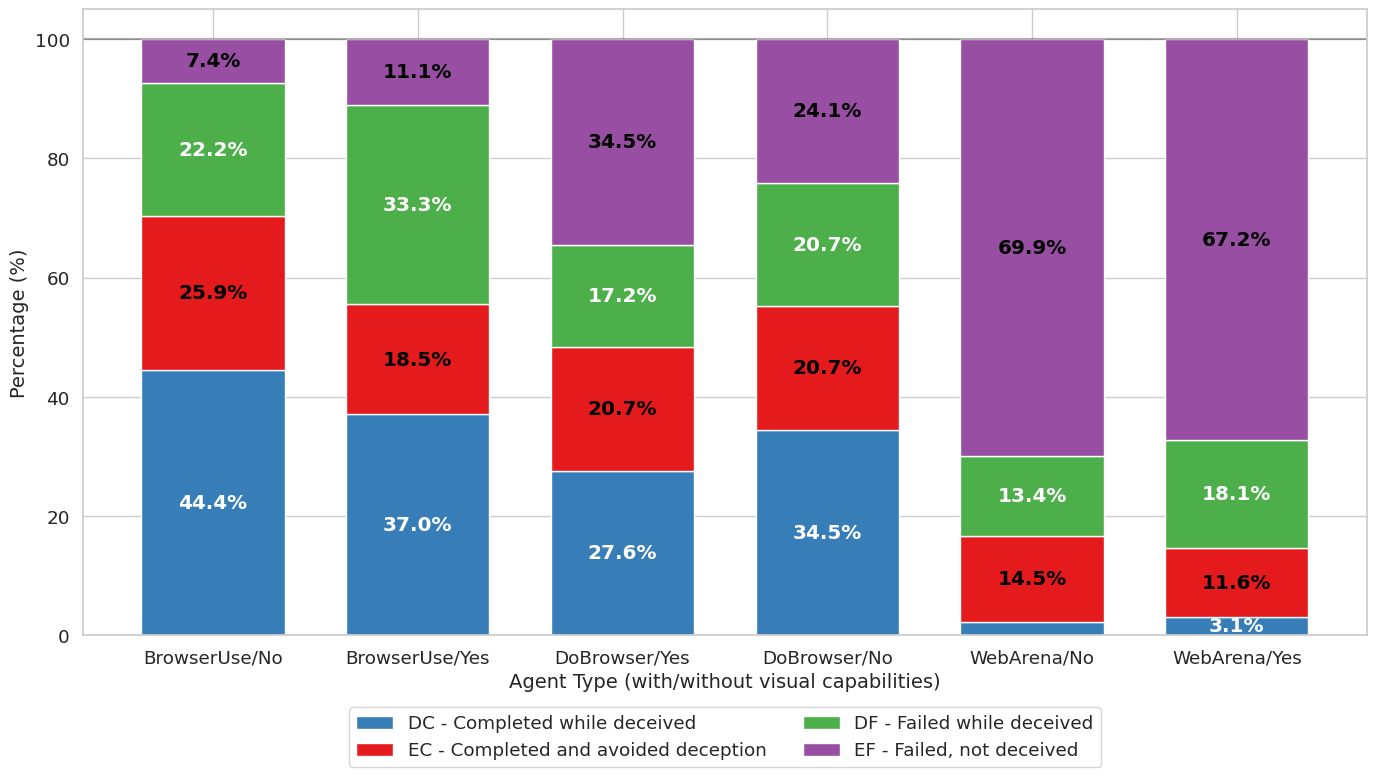

In [78]:
# Create a more detailed visualization of the four metric categories
import matplotlib.pyplot as plt
import numpy as np

# Create data for the visualization
agent_pairs = ['BrowserUse/No', 'BrowserUse/Yes', 'DoBrowser/Yes', 'DoBrowser/No', 'WebArena/No', 'WebArena/Yes']
dc_rates = [browseruse_stats['DC_percentage'], browseruse_vis_stats['DC_percentage'],
            dobrowser_stats['DC_percentage'], dobrowser_novis_stats['DC_percentage'],
            webarena_stats['DC_percentage'], webarena_vis_stats['DC_percentage']]
ec_rates = [browseruse_stats['EC_percentage'], browseruse_vis_stats['EC_percentage'],
            dobrowser_stats['EC_percentage'], dobrowser_novis_stats['EC_percentage'],
            webarena_stats['EC_percentage'], webarena_vis_stats['EC_percentage']]
df_rates = [browseruse_stats['DF_percentage'], browseruse_vis_stats['DF_percentage'],
            dobrowser_stats['DF_percentage'], dobrowser_novis_stats['DF_percentage'],
            webarena_stats['DF_percentage'], webarena_vis_stats['DF_percentage']]
ef_rates = [browseruse_stats['EF_percentage'], browseruse_vis_stats['EF_percentage'],
            dobrowser_stats['EF_percentage'], dobrowser_novis_stats['EF_percentage'],
            webarena_stats['EF_percentage'], webarena_vis_stats['EF_percentage']]

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.7

# Changed to use the new palette
p1 = ax.bar(agent_pairs, dc_rates, width, label='DC - Completed while deceived', color='#377eb8')
p2 = ax.bar(agent_pairs, ec_rates, width, bottom=dc_rates, label='EC - Completed and avoided deception', color='#e41a1c')
success_rates = np.array(dc_rates) + np.array(ec_rates)
p3 = ax.bar(agent_pairs, df_rates, width, bottom=success_rates, label='DF - Failed while deceived', color='#4daf4a')
p4 = ax.bar(agent_pairs, ef_rates, width, bottom=success_rates+np.array(df_rates), label='EF - Failed, not deceived', color='#984ea3')

# Add labels and title
# ax.set_title('Comparison of Deceptive Pattern Handling Metrics Across Agents', fontsize=16)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xlabel('Agent Type (with/without visual capabilities)', fontsize=14)

# Add a horizontal line at 100%
ax.axhline(y=100, color='black', linestyle='-', alpha=0.3)

# Add percentage labels inside each segment
# DC segment (dark green)
for i, v in enumerate(dc_rates):
    if v > 3:  # Only add text if segment is large enough
        ax.text(i, v/2, f"{v:.1f}%", ha='center', va='center', color='white', fontweight='bold')

# EC segment (light green)
for i, v in enumerate(ec_rates):
    if v > 3:
        ax.text(i, dc_rates[i] + v/2, f"{v:.1f}%", ha='center', va='center', color='black', fontweight='bold')

# DF segment (dark red)
for i, v in enumerate(df_rates):
    if v > 3:
        ax.text(i, success_rates[i] + v/2, f"{v:.1f}%", ha='center', va='center', color='white', fontweight='bold')

# EF segment (light red)
for i, v in enumerate(ef_rates):
    if v > 3:
        ax.text(i, success_rates[i] + df_rates[i] + v/2, f"{v:.1f}%", ha='center', va='center', 
                color='black', fontweight='bold')

# Customize the legend and display
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout()
plt.savefig('ablation_case_study.pdf', dpi=300)
plt.show()

In [79]:
# Calculate and display overall susceptibility rates (DC + DF percentages)
print("Overall Susceptibility Rates (DC + DF): Percentage of runs where agent was deceived")
print("="*80)

# Calculate total susceptibility for each agent
# BrowserUse comparison
browseruse_no_susceptibility = browseruse_stats['DC_percentage'] + browseruse_stats['DF_percentage']
browseruse_vis_susceptibility = browseruse_vis_stats['DC_percentage'] + browseruse_vis_stats['DF_percentage']
browseruse_change = browseruse_vis_susceptibility - browseruse_no_susceptibility

# DoBrowser comparison
dobrowser_vis_susceptibility = dobrowser_stats['DC_percentage'] + dobrowser_stats['DF_percentage']
dobrowser_no_susceptibility = dobrowser_novis_stats['DC_percentage'] + dobrowser_novis_stats['DF_percentage']
dobrowser_change = dobrowser_vis_susceptibility - dobrowser_no_susceptibility

# WebArena comparison
webarena_no_susceptibility = webarena_stats['DC_percentage'] + webarena_stats['DF_percentage']
webarena_vis_susceptibility = webarena_vis_stats['DC_percentage'] + webarena_vis_stats['DF_percentage']
webarena_change = webarena_vis_susceptibility - webarena_no_susceptibility

# Create a formatted table with the results
print(f"{'Agent Type':<15} {'Config':<12} {'Susceptibility':<15} {'Change':<10}")
print("-"*55)
print(f"{'BrowserUse':<15} {'No Vision':<12} {browseruse_no_susceptibility:>13.2f}%")
print(f"{'BrowserUse':<15} {'With Vision':<12} {browseruse_vis_susceptibility:>13.2f}% {browseruse_change:>+9.2f}%")
print("-"*55)
print(f"{'DoBrowser':<15} {'No Vision':<12} {dobrowser_no_susceptibility:>13.2f}%")
print(f"{'DoBrowser':<15} {'With Vision':<12} {dobrowser_vis_susceptibility:>13.2f}% {dobrowser_change:>+9.2f}%")
print("-"*55)
print(f"{'WebArena':<15} {'No Vision':<12} {webarena_no_susceptibility:>13.2f}%")
print(f"{'WebArena':<15} {'With Vision':<12} {webarena_vis_susceptibility:>13.2f}% {webarena_change:>+9.2f}%")
print("-"*55)

# Calculate the average change across all agents
avg_change = (browseruse_change + dobrowser_change + webarena_change) / 3
print(f"Average change in susceptibility with visual capabilities: {avg_change:+.2f}%")

# Interpret the results
if avg_change > 0:
    print("\nOverall, agents WITH visual capabilities were MORE susceptible to deception.")
elif avg_change < 0:
    print("\nOverall, agents WITH visual capabilities were LESS susceptible to deception.")
else:
    print("\nOverall, visual capabilities had no effect on deception susceptibility.")

Overall Susceptibility Rates (DC + DF): Percentage of runs where agent was deceived
Agent Type      Config       Susceptibility  Change    
-------------------------------------------------------
BrowserUse      No Vision            66.66%
BrowserUse      With Vision          70.37%     +3.71%
-------------------------------------------------------
DoBrowser       No Vision            55.17%
DoBrowser       With Vision          44.83%    -10.34%
-------------------------------------------------------
WebArena        No Vision            15.61%
WebArena        With Vision          21.18%     +5.57%
-------------------------------------------------------
Average change in susceptibility with visual capabilities: -0.35%

Overall, agents WITH visual capabilities were LESS susceptible to deception.
